# Karten-Generierung mit Diffusionsmodell (INRIA Aerial Dataset)

Dieses Notebook trainiert ein einfaches Diffusionsmodell auf Stadt-Luftbildern.
Optional können Gebäude-Masken als Bedingung verwendet werden (Skizzen oder Kontrolle).

In [ ]:
from PIL import Image
import os
from glob import glob

input_dir = "data/aerialimagelabeling/train/" 


output_img_dir = "data/aerialimagelabeling/transformed/rgb_patches_128_overlap64"
output_mask_dir = "data/aerialimagelabeling/transformed/mask_patches_128_overlap64"


os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)


def extract_patches(img, tile_size=128, overlap=64):
    step = tile_size-overlap
    patches = []

    for y in range(0, img.height - tile_size + 1, step):
        for x in range(0, img.width - tile_size + 1, step):
            patch = img.crop((x, y, x + tile_size, y + tile_size))
            patches.append(((x,y), patch))
    return patches

#Alle *_sat.jpg Bilder finden und dazugehörige Masken verarbeiten 
image_paths = sorted(glob(os.path.join(input_dir, "*_sat.jpg")))

for img_path in image_paths:
    basename = os.path.basename(img_path).replace("_sat.jpg", "")
    mask_path = os.path.join(input_dir, f"{basename}_mask.png")
    
    if not os.path.exists(mask_path):
        print(f"⚠️ Maske fehlt für {basename}, überspringe...")
        continue


    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    img_patches = extract_patches(image)
    mask_patches = extract_patches(mask)

    
    # Speichern
    for ((x, y), patch_img), ((_, _), patch_mask) in zip(img_patches, mask_patches):
        filename = f"{basename}_{x}_{y}.png"
        patch_img.save(os.path.join(output_img_dir, filename))
        patch_mask.save(os.path.join(output_mask_dir, filename))

print("Alle Patches wurden erfolgreich erstellt und gespeichert.")



In [20]:
#Einzelnes Bild verarbeiten

from PIL import Image
import os

# === 1. Test-Dateien definieren ===

input_dir = "data/aerialimagelabeling/train/" 


output_img_dir = "data/aerialimagelabeling/transformed/rgb_patches_128_overlap64"
output_mask_dir = "data/aerialimagelabeling/transformed/mask_patches_128_overlap64"



os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# === 2. Datei-ID festlegen ===
basename = "104"
img_path = os.path.join(input_dir, f"{basename}_sat.jpg")
mask_path = os.path.join(input_dir, f"{basename}_mask.png")

# === 3. Bild und Maske laden ===
image = Image.open(img_path).convert("RGB")
mask = Image.open(mask_path).convert("L")

# === 4. Funktion zum sicheren Zuschneiden ===
def extract_patches(img, tile_size=128, overlap=64):
    step = tile_size - overlap
    patches = []
    w, h = img.size
    for y in range(0, h, step):
        for x in range(0, w, step):
            if x + tile_size <= w and y + tile_size <= h:
                patch = img.crop((x, y, x + tile_size, y + tile_size))
                patches.append(((x, y), patch))
    return patches

# === 5. Patches erzeugen ===
img_patches = extract_patches(image)
mask_patches = extract_patches(mask)

# === 6. Ergebnisse speichern ===
for i, (((x, y), patch_img), ((_, _), patch_mask)) in enumerate(zip(img_patches, mask_patches)):
    filename = f"{basename}_Part_{i+1}.png"

    # Ordner für dieses Bild anlegen (einmalig)
    img_output_subdir = os.path.join(output_img_dir, basename)
    mask_output_subdir = os.path.join(output_mask_dir, basename)
    os.makedirs(img_output_subdir, exist_ok=True)
    os.makedirs(mask_output_subdir, exist_ok=True)

    # Dateien speichern in jeweiligem Unterordner
    patch_img.save(os.path.join(img_output_subdir, filename))
    patch_mask.save(os.path.join(mask_output_subdir, filename))

print("Testbild erfolgreich in Patches zerlegt und gespeichert.")

Testbild erfolgreich in Patches zerlegt und gespeichert.


In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t- 0.5) * 2),
])

train_dataset = MNIST(root="data", train=True, download=True, transform=transform )
dataloader = DataLoader(train_dataset, batch_size =32, shuffle=True)


target_class = 3

# 🔧 Filtere alle Indizes mit y == 3
filtered_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == target_class]

# Erstelle Subset
filtered_dataset = Subset(train_dataset, filtered_indices)

# DataLoader
filtered_dataloader = DataLoader(filtered_dataset, batch_size=32, shuffle=True)


In [21]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class MaskToRGBDataset(Dataset):

    def __init__(self, mask_root, rgb_root, transform=None):

        self.transform = transform if transform else T.Compose([
            T.Resize((128,128)),
            T.ToTensor(),
        ])
        
        self.paths = []

        for folder in os.listdir(mask_root):
            mask_dir = os.path.join(mask_root, folder)
            rgb_dir = os.path.join(rgb_root, folder)
            if not os.path.isdir(mask_dir):
                continue
            for fname in os.listdir(mask_dir):
                mask_path = os.path.join(mask_dir, fname)
                rgb_path = os.path.join(rgb_dir, fname)
                if os.path.exists(rgb_path):
                    self.paths.append((mask_path, rgb_path))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        mask_path, rgb_path = self.paths[idx]
        mask = Image.open(mask_path).convert("L")
        rgb = Image.open(rgb_path).convert("RGB")

        mask = self.transform(mask) * 2 - 1  # [-1, 1]
        rgb = self.transform(rgb) * 2 - 1

        #return mask, rgb
        return rgb

In [ ]:
import torch

T = 1000
betas = torch.linspace(1e-4, 0.02, T)   #Linear Noise
alphas = 1 - betas
alpha_hat = torch.cumprod(alphas, dim=0)

In [22]:
import torch

class DDPM:
    def __init__(self, model, n_steps=1000, beta_start=1e-4, beta_end=0.02):
        self.model = model
        self.n_steps = n_steps

        # Lineare Noise-Rate
        self.betas = torch.linspace(beta_start, beta_end, n_steps)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise):
        """
        Simuliert ein verrauschtes Bild zu Zeit t
        """
        sqrt_alpha_hat = self.alpha_hat[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus = (1 - self.alpha_hat[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_hat * x_start + sqrt_one_minus * noise

    def p_losses(self, x_start, mask_cond, t):
        """
        Trainingsloss: vorhergesagter vs. tatsächlicher Rauschterm
        """
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)

        # Input ist Maske + verrauschtes Bild
        #model_input = torch.cat([mask_cond, x_noisy], dim=1)
        #predicted_noise = self.model(model_input, t)

        predicted_noise = self.model(x_noisy, t)
        return torch.nn.functional.mse_loss(predicted_noise, noise)

In [ ]:
def forward_diffusion_sample(x_0, t, noise):
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:,None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1- alpha_hat[t])[:, None, None, None]
    
    return sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise

In [ ]:
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28)
        )
        self.net = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, x, t):
        # Zeitstempel als Feature
        t = t.float().view(-1, 1) / 1000
        time_embedding = self.time_mlp(t).view(-1, 1, 28, 28)
        x = torch.cat([x, time_embedding], dim=1)
        return self.net(x)


In [ ]:
#U Net

import torch.nn as nn

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()


        self.time_mlp = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 256)
        )

        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)  # 28x28 → 14x14
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)  # 14x14 → 7x7

        # Bottleneck
        self.bottleneck = conv_block(128, 256)

        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 7x7 → 14x14
        self.dec2 = conv_block(256, 128)  # 128 von upsample + 128 von enc2

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # 14x14 → 28x28
        self.dec1 = conv_block(128, 64)  # 64 von upsample + 64 von enc1

        # Output-Schicht
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, t):
        
        t = t.float().view(-1, 1) / 1000
        time_embed = self.time_mlp(t).view(-1, 256, 1, 1)


        # Encoder
        x1 = self.enc1(x)                 # [B, 64, 28, 28]
        x2 = self.enc2(self.pool1(x1))    # [B, 128, 14, 14]
        x3 = self.bottleneck(self.pool2(x2))  + time_embed  # [B, 256, 7, 7]

        # Decoder
        x = self.up2(x3)                  # [B, 128, 14, 14]
        x = torch.cat([x, x2], dim=1)     # [B, 256, 14, 14]
        x = self.dec2(x)                  # [B, 128, 14, 14]

        x = self.up1(x)                   # [B, 64, 28, 28]
        x = torch.cat([x, x1], dim=1)     # [B, 128, 28, 28]
        x = self.dec1(x)                  # [B, 64, 28, 28]

        return self.final(x)              # [B, 1, 28, 28]

In [23]:
#UNet RGB

import torch.nn as nn
import torch

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )

class UNetRGB(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):  
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 256)
        )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, t):
        t = t.float().view(-1, 1) / 1000  
        time_embed = self.time_mlp(t).view(-1, 256, 1, 1)

        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.bottleneck(self.pool2(x2)) + time_embed
        x = self.up2(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)
        return self.final(x)


In [ ]:
from tqdm import tqdm

def train(model, dataloader, optimizer, device):
    model.train()
    all_losses = []
    for epoch in range(5):
        print(f"Epoch {epoch+1}")
        progress_bar = tqdm(dataloader)
        for x, _ in progress_bar:
            x = x.to(device)
            t = torch.randint(0, T, (x.size(0),), device=device).long()
            noise = torch.randn_like(x)
            x_noisy = forward_diffusion_sample(x, t, noise)
            noise_pred = model(x_noisy, t)
            loss = nn.functional.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            all_losses.append(loss.item())  # speichere Loss
            progress_bar.set_description(f"Loss: {loss.item():.4f}")
            
    return all_losses  # gibt am Ende alle Loss-Werte zurück

In [30]:
#Train RGB

from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm

mask_root = "data/aerialimagelabeling/transformed/rgb_patches_128_overlap64"
rgb_root = "data/aerialimagelabeling/transformed/mask_patches_128_overlap64"
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Daten laden
dataset = MaskToRGBDataset(mask_root, rgb_root)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#odell & Diffusion
#model = UNetRGB(in_channels=4, out_channels=3).to(device)

model = UNetRGB(in_channels=3, out_channels=3).to(device)

ddpm = DDPM(model)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 10
for epoch in range(n_epochs):
    for mask, rgb in tqdm.tqdm(dataloader):
        mask, rgb = mask.to(device), rgb.to(device)

        t = torch.randint(0, ddpm.n_steps, (rgb.size(0),), device=device).long()
        loss = ddpm.p_losses(x_start=rgb, mask_cond=mask, t=t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {loss.item():.4f}")


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


Epoch 1/10 | Loss: 0.9782


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


Epoch 2/10 | Loss: 0.9017


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Epoch 3/10 | Loss: 0.7844


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Epoch 4/10 | Loss: 0.5821


100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


Epoch 5/10 | Loss: 0.4075


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


Epoch 6/10 | Loss: 0.2168


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


Epoch 7/10 | Loss: 0.1971


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


Epoch 8/10 | Loss: 0.0741


100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


Epoch 9/10 | Loss: 0.0595


100%|██████████| 15/15 [00:36<00:00,  2.45s/it]

Epoch 10/10 | Loss: 0.0465


In [ ]:
@torch.no_grad()
def sample(model, shape, device):
    x = torch.randn(shape).to(device)  # Start mit reinem Rauschen
    for t in reversed(range(T)):
        t_batch = torch.full((shape[0],), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_hat_t = alpha_hat[t]
        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * noise_pred)
        if t > 0:
            z = torch.randn_like(x)
            x += torch.sqrt(beta_t) * z
    return x


In [31]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_from_model(ddpm, mask, device, n_steps=1000):
    model = ddpm.model
    model.eval()

    # Bildgröße und Batch ableiten
    B, _, H, W = mask.shape

    # 1. Initialisiere RGB-Bild mit reinem Rauschen
    x = torch.randn(B, 3, H, W).to(device)

    for t_step in reversed(range(n_steps)):
        t = torch.full((B,), t_step, device=device, dtype=torch.long)

        # Verbinde Maske + momentanen Bildzustand
        model_input = torch.cat([mask, x], dim=1)
        predicted_noise = model(model_input, t)

        alpha = ddpm.alphas[t].view(-1, 1, 1, 1)
        alpha_hat = ddpm.alpha_hat[t].view(-1, 1, 1, 1)
        beta = ddpm.betas[t].view(-1, 1, 1, 1)

        # Rekonstruiere vorherigen Zustand
        x = (1 / alpha.sqrt()) * (x - (1 - alpha) / (1 - alpha_hat).sqrt() * predicted_noise)

        # Falls nicht der letzte Schritt → füge leichtes neues Rauschen hinzu
        if t_step > 0:
            noise = torch.randn_like(x)
            x += beta.sqrt() * noise

    return x


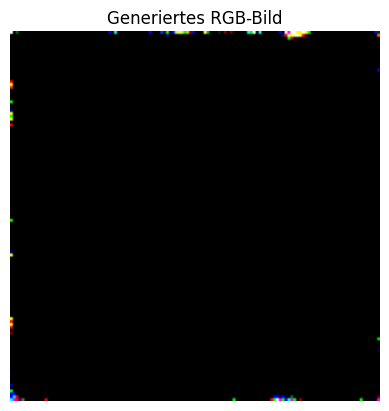

In [32]:
# Beispielmaske laden
mask_image = Image.open("data/aerialimagelabeling/transformed/mask_patches_128_overlap64/104/104_Part_81.png").convert("L")
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])
mask_tensor = transform(mask_image).unsqueeze(0).to(device) * 2 - 1  # [1, 1, 128, 128]

# Samplen
generated_rgb = sample_from_model(ddpm, mask_tensor, device)  # → [1, 3, 128, 128]

# zurückskalieren und anzeigen
to_img = lambda x: (x.clamp(-1, 1) + 1) / 2
img = to_img(generated_rgb[0]).cpu().permute(1, 2, 0).numpy()

plt.imshow(img)
plt.title("Generiertes RGB-Bild")
plt.axis("off")
plt.show()


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Trainieren
losses = train(model, dataloader, optimizer, device)






In [ ]:
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

samples = sample(model, shape=(16, 1, 28, 28), device=device)

for i in range(16):
    plt.imshow((samples[i][0].cpu().numpy() + 1) / 2, cmap="gray")
    plt.axis("off")
    plt.show()